# Router

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import rich

from dotenv import load_dotenv

load_dotenv()


OPENAI_API_TOKEN = os.getenv("OPENAI_API_TOKEN")

In [2]:
from haystack import Pipeline
from haystack.utils import Secret
from haystack.components.routers import ConditionalRouter
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack.components.generators import OpenAIGenerator

routes = [
        {
            "condition": "{{query|length > 10}}",
            "output": "{{query}}",
            "output_name": "ok_query",
            "output_type": str,
        },
        {
            "condition": "{{query|length <= 10}}",
            "output": "{{query}}",
            "output_name": "too_short_query",
            "output_type": str,
        },
    ]
router = ConditionalRouter(routes=routes)

pipe = Pipeline()
pipe.add_component("router", router)
pipe.add_component("prompt_builder_ok_query", PromptBuilder("Answer the following query. {{query}}"))
pipe.add_component("prompt_builder_too_short_query", PromptBuilder("Invent a max 6 words query based on the following short query and answer it. {{query}}"))

pipe.add_component("generator_ok_query", OpenAIGenerator(model="gpt-4o-mini-2024-07-18", api_key=Secret.from_token(OPENAI_API_TOKEN)))
pipe.add_component("generator_too_short_query", OpenAIGenerator(model="gpt-4o-mini-2024-07-18", api_key=Secret.from_token(OPENAI_API_TOKEN)))

pipe.connect("router.ok_query", "prompt_builder_ok_query.query")
pipe.connect("router.too_short_query", "prompt_builder_too_short_query.query")
pipe.connect("prompt_builder_ok_query", "generator_ok_query")
pipe.connect("prompt_builder_too_short_query", "generator_too_short_query")

🚅 Components
  - router: ConditionalRouter
  - prompt_builder_ok_query: PromptBuilder
  - prompt_builder_too_short_query: PromptBuilder
  - generator_ok_query: OpenAIGenerator
  - generator_too_short_query: OpenAIGenerator
🛤️ Connections
  - router.ok_query -> prompt_builder_ok_query.query (str)
  - router.too_short_query -> prompt_builder_too_short_query.query (str)
  - prompt_builder_ok_query.prompt -> generator_ok_query.prompt (str)
  - prompt_builder_too_short_query.prompt -> generator_too_short_query.prompt (str)

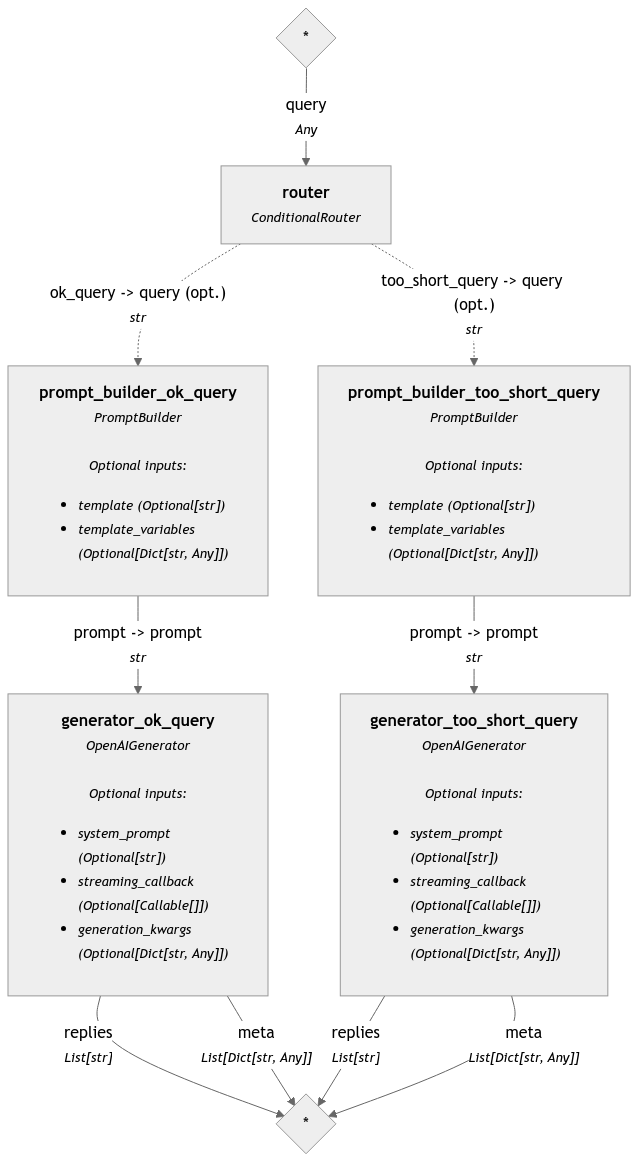

In [3]:
pipe.show()

In [4]:
pipe.run(data={"router": {"query": "Berlin"}}, include_outputs_from="router")

{'generator_too_short_query': {'replies': ['**Query:** Best attractions to visit in Berlin?  \n**Answer:** Brandenburg Gate, Berlin Wall, Museum Island.'],
  'meta': [{'model': 'gpt-4o-mini-2024-07-18',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 24,
     'prompt_tokens': 25,
     'total_tokens': 49,
     'completion_tokens_details': CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0),
     'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)}}]},
 'router': {'too_short_query': 'Berlin'}}

In [5]:
pipe.run(data={"router": {"query": "What is the capital of Italy?"}}, include_outputs_from="router")

{'generator_ok_query': {'replies': ['The capital of Italy is Rome.'],
  'meta': [{'model': 'gpt-4o-mini-2024-07-18',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 8,
     'prompt_tokens': 19,
     'total_tokens': 27,
     'completion_tokens_details': CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0),
     'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)}}]},
 'router': {'ok_query': 'What is the capital of Italy?'}}